In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import requests
import numpy as np
import csv
import os
from tensorflow.python.framework import ops

In [3]:
birth_weight_file = "../data/birthweight.dat"
if not os.path.exists(birth_weight_file):
    birthdata_url = "https://raw.githubusercontent.com/nfmcclure/" \
        "tensorflow_cookbook/master/01_Introduction/07_Working_with_Data_Sources/" \
        "birthweight_data/birthweight.dat"
    birth_file = requests.get(birthdata_url)
    birth_data = birth_file.text.split('\r\n')
    birth_header = birth_data[0].split('\t')
    birth_data = [[float(x) for x in y.split('\t') if len(x) >= 1]
        for y in birth_data[1:] if len(y) >= 1]
    with open(birth_weight_file, "w") as f:
        writer = csv.writer(f)
        writer.writerow(birth_header)
        writer.writerows(birth_data)
        
birth_data = []
with open(birth_weight_file, newline='') as csvfile:
    csv_reader = csv.reader(csvfile)
    birth_header = next(csv_reader)
    for row in csv_reader:
        birth_data.append([float(x) for x in row])
        
y_vals = np.array([x[0] for x in birth_data])
x_vals = np.array([x[2:9] for x in birth_data])

In [4]:
train_indices = np.random.choice(len(x_vals), round(len(x_vals) * 0.8),
                                replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

def normalize_cols(m):
    col_max = m.max(axis=0)
    col_min = m.min(axis=0)
    return (m - col_min) / (col_max - col_min)

x_vals_train = np.nan_to_num(normalize_cols(x_vals_train))
x_vals_test = np.nan_to_num(normalize_cols(x_vals_test))

In [14]:
ops.reset_default_graph()
with tf.Session() as sess:
    def init_variable(shape):
        return tf.Variable(tf.random_normal(shape))
    def logistic(input_layer, multiplication_weights, bias_weights, activation=True):
        linear_layer = tf.add(tf.matmul(input_layer, multiplication_weights), bias_weights)
        if activation:
            return tf.nn.sigmoid(linear_layer)
        else:
            return linear_layer
    
    bs = 90
    lr = 0.002
    it = 1500
    x_data = tf.placeholder(shape=[None, 7], dtype=tf.float32)
    y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)
    
    A1 = init_variable(shape=[7, 14])
    b1 = init_variable(shape=[14])
    logistic_layer_1 = logistic(x_data, A1, b1)

    A2 = init_variable(shape=[14, 5])
    b2 = init_variable(shape=[5])
    logistic_layer_2 = logistic(logistic_layer_1, A2, b2)
    
    A3 = init_variable(shape=[5, 1])
    b3 = init_variable(shape=[1])
    final_output = logistic(logistic_layer_2, A3, b3, activation=False)

    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=final_output, labels=y_target))
    my_opt = tf.train.AdamOptimizer(lr)
    train_step = my_opt.minimize(loss)
    
    init = tf.global_variables_initializer()
    sess.run(init)
    
    prediction = tf.round(tf.sigmoid(final_output))
    predictions_correct = tf.cast(tf.equal(prediction, y_target), tf.float32)
    accuracy = tf.reduce_mean(predictions_correct)
    
    loss_vec = []
    train_acc = []
    test_acc = []
    for i in range(it):
        rand_index = np.random.choice(len(x_vals_train), size=bs)
        rand_x = x_vals_train[rand_index]
        rand_y = np.transpose([y_vals_train[rand_index]])
        sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
        temp_loss = sess.run(loss, feed_dict={
            x_data: rand_x,
            y_target: rand_y})
        loss_vec.append(temp_loss)
        
        temp_train_acc = sess.run(accuracy, feed_dict={
            x_data: x_vals_train,
            y_target: np.transpose([y_vals_train])})
        train_acc.append(temp_train_acc)
        
        temp_test_acc = sess.run(accuracy, feed_dict={
            x_data: x_vals_test,
            y_target: np.transpose([y_vals_test])})
        test_acc.append(temp_test_acc)
        
        if (i + 1) % 150 == 0:
            print('Loss = ' + str(temp_loss))

Loss = 0.6269639
Loss = 0.522981
Loss = 0.4966232
Loss = 0.4476755
Loss = 0.44833437
Loss = 0.38115448
Loss = 0.3442483
Loss = 0.31668863
Loss = 0.21211769
Loss = 0.25659168


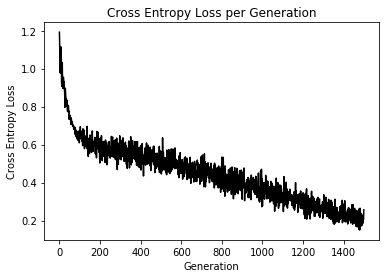

In [15]:
plt.plot(loss_vec, 'k-')
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.show()

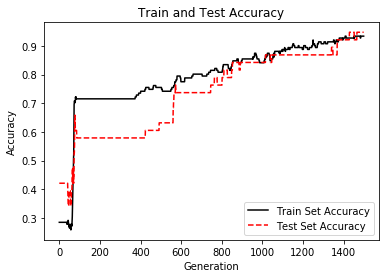

In [16]:
plt.plot(train_acc, 'k-', label='Train Set Accuracy')
plt.plot(test_acc, 'r--', label='Test Set Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()